# Calibrating machine-learning models to increase the prediction accuracy of specific experiments
### Aleš Křenek
#### Sitola, 22.9.2021

In [99]:
#trainf='train_positive.tsv'
#trainf=''
featf='features.csv'

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd,chdir

from moldescriptors import get_features
from main import make_preds

datadir='/data'
prefix='/opt/callc/rt/'
modlib=prefix + 'mods_l1/'
#models=['adaboost','bayesianregr','lasso']
models=['bayesianregr','lasso']

featn=[x.strip() for x in open(prefix+"features/selected_features.txt").readlines()]
featn.remove('system')

## Train a fresh model with our data

In [100]:
from sklearn.linear_model import ARDRegression
from scipy.stats import randint
from scipy.stats import uniform
import random
random.seed(815)

model = ARDRegression()
params = {
        "n_iter" : randint(100,1500),
        "alpha_1" : uniform(1e-10,1e-2),
        "lambda_1" : uniform(1e-10,1e-2),
        "threshold_lambda" : randint(1,10000),
    }


In [101]:
with open('feats_lib.csv','w'): pass

#trainf='train_positive.tsv'
#trainpos = pd.read_csv(trainf,sep='\t')
get_features(infile_name='train_positive.tsv',outfile_name=featf,id_index=3,mol_index=0,time_index=2)
#get_features(infile_name='aicheler_data.csv',outfile_name=featf,id_index=0,mol_index=1,time_index=2)




features = pd.read_csv(featf)[featn]
features.shape

(175, 159)

In [102]:
features[:5]

,IDENTIFIER,time,fr_C_O_noCOO,PEOE_VSA3,Chi4v,fr_Ar_COO,fr_SH,Chi4n,SMR_VSA10,fr_para_hydroxylation,...,fr_phenol,MolMR,PEOE_VSA9,fr_aldehyde,fr_pyridine,fr_tetrazole,fr_nitro_arom_nonortho,Chi0v,NumRotatableBonds,MaxAbsPartialCharge
0,1,876.6,2,18.559346,3.293558,0,0,2.524424,52.428500,0,...,0,113.6279,15.608718,0,1,0,0,18.504913,4,0.434389
1,2,921.6,0,0.000000,11.278710,0,0,11.278710,5.969305,0,...,0,188.7364,72.558621,0,0,0,0,32.838949,9,0.480963
2,3,162.6,0,0.000000,0.554594,0,0,0.381411,23.497618,0,...,0,33.6618,0.000000,0,0,0,0,5.130235,0,0.367607
3,4,227.4,0,4.565048,1.783489,0,1,0.363556,19.046256,0,...,0,39.8445,13.213764,0,0,0,0,7.322240,4,0.385581
4,5,621.0,1,0.000000,1.471488,0,0,1.471488,5.907180,0,...,0,58.4305,0.000000,0,0,0,0,9.079077,3,0.339206


In [103]:
from random import shuffle
testsize=int(len(features.index)*.2)
index=list(range(len(features.index)))
shuffle(index)
test=features.iloc[index[:testsize]]
train=features.iloc[index[testsize:]]

In [104]:
from sklearn.model_selection import KFold
from trainl1 import train_model_l1
cv = list(KFold(n_splits=10,shuffle=True).split(train.index))
# cv = None #XXX
model,preds = train_model_l1(train.drop(["time","IDENTIFIER","system"],axis=1, errors="ignore"),
                                             train["time"],params,model,
                                             cv = cv,n_params=20,
                                             n_jobs=4)

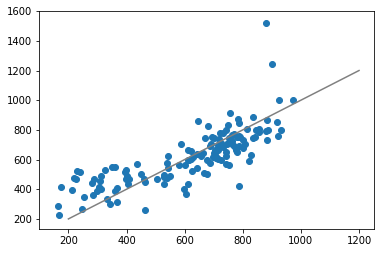

In [105]:
plt.plot([200,1200],[200,1200],color='grey')
plt.scatter(train['time'],preds)
plt.show()

In [106]:
test_preds = pd.DataFrame(
    model.predict(test.drop(["time","IDENTIFIER"],axis=1)),
    index=test.index,columns=['predictions'])

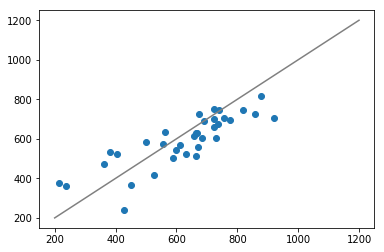

In [107]:
plt.plot([200,1200],[200,1200],color='grey')
plt.scatter(test['time'],test_preds)
plt.show()

In [108]:
def r2(measured,model):
    mean = np.average(measured)
    yres = measured-mean
    modres = model-measured
    ss_tot = np.sum(yres*yres)
    ss_res = np.sum(modres*modres)
    return 1. - ss_res/ss_tot

In [109]:
r2(np.array(train['time']),preds)

0.597020006297452

In [110]:
r2(np.array(test['time']),np.array(test_preds['predictions']))

0.65044836767467

## Apply available models on our data

In [111]:
def apply_model(X,modname):
    modf=modlib + modname + '42.pickle'
    print('opening ',modf)
    with open(modf,"rb") as m:
        model = pickle.load(m,encoding='latin1')
    preds=model.predict(X)
    return preds

In [112]:
dataset='MTBLS20'
preds={}
for m in models:
    preds[m] = apply_model(features.drop(['IDENTIFIER','time'],axis=1),modname=dataset+'_'+m)

opening  /opt/callc/rt/mods_l1/MTBLS20_bayesianregr42.pickle
opening  /opt/callc/rt/mods_l1/MTBLS20_lasso42.pickle


/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


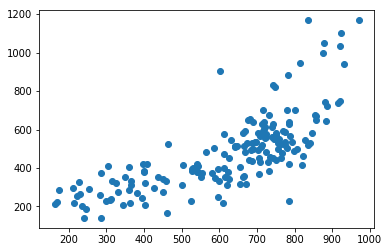

In [113]:
bayes_good=(preds['bayesianregr'] < 1200)
plt.scatter(np.array(features['time'])[bayes_good],preds['bayesianregr'][bayes_good])

In [114]:
r2(np.array(features['time'])[bayes_good],preds['bayesianregr'][bayes_good])

0.003468672867390832

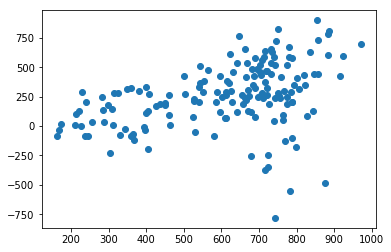

In [115]:
lasso_good=(np.abs(preds['lasso']) < 1000)
plt.scatter(np.array(features['time'])[lasso_good],preds['lasso'][lasso_good])

In [116]:
r2(np.array(features['time'])[lasso_good],preds['lasso'][lasso_good])

-4.261710291660824

## Employ the big beast

In [117]:
chdir(datadir)
train.to_csv('reference.csv')
test.to_csv('test.csv')
chdir(prefix)
make_preds(reference_infile=datadir + '/reference.csv',pred_infile=datadir + '/test.csv',
           outfile=datadir+'/test_preds')

Total number of train molecules with tR: 140
Training Layer 1 LASSO


/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training Layer 1 AdaBoost


/opt/conda/envs/callc/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/envs/callc/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/opt/conda/envs/callc/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Training Layer 1 XGBoost
Training Layer 1 SVR
Training Layer 1 BRR
Applying model: mods_l1/FEM_orbitrap_urine_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/FEM_orbitrap_urine_adaboost42.pickle'>
Could not execute: mods_l1/FEM_orbitrap_urine_adaboost42.pickle local variable 'model' referenced before assignment
Applying model: mods_l1/PFR-TK72_bayesianregr42.pickle
Applying model: mods_l1/FEM_orbitrap_plasma_SVM42.pickle
Applying model: mods_l1/1290SQ_lasso42.pickle
Applying model: mods_l1/MPI_Symmetry_lasso42.pickle
Applying model: mods_l1/MTBLS19_bayesianregr42.pickle
Applying model: mods_l1/MTBLS87_SVM42.pickle
Applying model: mods_l1/MTBLS36_lasso42.pickle
Applying model: mods_l1/MTBLS17_lasso42.pickle
Applying model: mods_l1/MTBLS20_lasso42.pickle
Applying model: mods_l1/Ken_lasso42.pickle
Applying model: mods_l1/Krauss_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/Krauss_adaboost42.pickle'>
Applying model: mods_l1/UniToyama_Atlantis_lasso

/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator Lasso from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results.

Applying model: mods_l1/MTBLS52_lasso42.pickle
Applying model: mods_l1/MTBLS20_SVM42.pickle
Applying model: mods_l1/1290SQ_SVM42.pickle
Applying model: mods_l1/FEM_lipids_SVM42.pickle
Applying model: mods_l1/Mark_bayesianregr42.pickle
Applying model: mods_l1/Ken_SVM42.pickle
Applying model: mods_l1/MTBLS20_bayesianregr42.pickle
Applying model: mods_l1/Eawag_XBridgeC18_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/Eawag_XBridgeC18_adaboost42.pickle'>
Applying model: mods_l1/MTBLS20_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS20_adaboost42.pickle'>
Applying model: mods_l1/Vogler_bayesianregr42.pickle
Applying model: mods_l1/MTBLS17_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS17_adaboost42.pickle'>
Applying model: mods_l1/MTBLS36_adaboost42.pickle
Unable to load: <_io.BufferedReader name='mods_l1/MTBLS36_adaboost42.pickle'>
Applying model: mods_l1/Mark_lasso42.pickle
Applying model: mods_l1/Cao_HILIC_adaboost4

/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator SVR from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/envs/callc/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator ARDRegression from version pre-0.18 when using version 0.20.0. This might lead to breaking code or invalid results. Use

Applying Layer 3...
Layer 3 fitted coefficient (MTBLS20_bayesianregr): 0.025
Layer 3 fitted coefficient (Eawag_XBridgeC18_adaboos): 0.026
Layer 3 fitted coefficient (MTBLS20_adaboos): 0.026
Layer 3 fitted coefficient (Cao_HILIC_bayesianregr): 0.017
Layer 3 fitted coefficient (c18pest_100_1_brr): 0.302
Layer 3 fitted coefficient (c18pest_60_1_xgb): 0.130
Layer 3 fitted coefficient (Toshimitsu_bayesianregr): 0.062
Layer 3 fitted coefficient (Tohge_bayesianregr): 0.137
Layer 3 fitted coefficient (FEM_long_SV): 0.186
Layer 3 fitted coefficient (Nikiforos_bayesianregr): 0.072
Layer 3 fitted coefficient (LIFE_new_bayesianregr): 0.106
Layer 3 fitted coefficient (MASSTRPLAN_adaboos): 0.033
Layer 3 sum coefficients: 1.123
Done, predictions can be found here: /data/test_preds.csv


In [118]:
chdir(datadir)
big_pred=pd.read_csv('test_preds.csv')

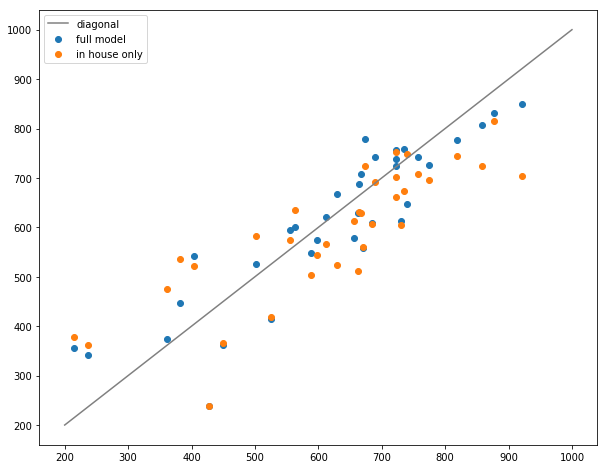

In [119]:
plt.figure(figsize=(10,8))
plt.plot([200,1000],[200,1000],label='diagonal',color='grey')
plt.scatter(test['time'],big_pred['predictions'],label='full model')
plt.scatter(test['time'],test_preds,label='in house only')
plt.legend()
plt.show()

In [120]:
r2(np.array(test['time']),np.array(test_preds['predictions']))

0.65044836767467

In [121]:
r2(np.array(test['time']),big_pred['predictions'])

0.7967941905716159